# SMS Spam Classification – Notebook corregido
Este cuaderno soluciona los errores de forma y vacíos que provocaban fallos en el entrenamiento.

## 0. Descarga y limpieza del dataset

In [2]:
import pandas as pd, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

!wget https://github.com/javierherrera1996/lecture_analytics/raw/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv

# Cargar CSV con codificación correcta y quedarnos con columnas relevantes
df = pd.read_csv('Gender_bias_spanish.csv', encoding='utf-8')
# Select the 'text' and 'label' columns
df = df[['Contents', 'Label']]
# Remove rows where the 'text' column is empty or null
df.dropna(subset=['Contents'], inplace=True)
df = df[df['Contents'].str.strip() != '']

# Display the first few rows to confirm
df.head()

--2025-05-28 21:45:14--  https://github.com/javierherrera1996/lecture_analytics/raw/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/javierherrera1996/lecture_analytics/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv [following]
--2025-05-28 21:45:14--  https://raw.githubusercontent.com/javierherrera1996/lecture_analytics/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 205292 (200K) [text/plain]
Saving to: ‘Gender_bias_spanish.csv’

Gender_bias_s

,Contents,Label
0,@chumeltorres ya cabrón! sin tí se reciben las...,biased
1,¿alguien es tan amable de ir a hacerme la comp...,non-biased
2,"@jenniferduquee hahaha, si está rico, nadamas ...",non-biased
3,@evagelcot donde lo ves!!? es mi programa favo...,non-biased
4,como siempre mi tortilla triunfa mas que otros...,non-biased


## 1. Configuración y seed

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
np.random.seed(42)
tf.random.set_seed(42)


## 2. División Train/Test

In [4]:
y = df['Label'].map({'biased':0,'non-biased':1})
X_train, X_test, y_train, y_test = train_test_split(
    df['Contents'], y, test_size=0.2, stratify=y, random_state=42)

print(len(X_train),"train |", len(X_test),"test")

1531 train | 383 test


## 3. Vectorización de texto con manejo seguro de dimensiones

In [5]:
MAX_TOKENS, MAX_LEN = 10000, 100
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_TOKENS,
    output_sequence_length=MAX_LEN,
    standardize="lower_and_strip_punctuation")
vectorizer.adapt(X_train.values)

def to_tensor(txt, label):
    txt = tf.expand_dims(txt, -1)          # (1,)
    seq = tf.squeeze(vectorizer(txt), axis=0) # (MAX_LEN,)
    return seq, label

batch = 32
train_ds = (tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
            .shuffle(10000)
            .map(to_tensor, num_parallel_calls=AUTOTUNE)
            .batch(batch)
            .prefetch(AUTOTUNE))
test_ds  = (tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))
            .map(to_tensor, num_parallel_calls=AUTOTUNE)
            .batch(batch)
            .prefetch(AUTOTUNE))

## 4. Definición y entrenamiento del modelo

In [7]:
EMBED_DIM = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_TOKENS, EMBED_DIM, input_length=MAX_LEN),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_ds, validation_data=test_ds, epochs=5)


Epoch 1/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8263 - loss: 0.5713 - val_accuracy: 0.8329 - val_loss: 0.4537
Epoch 2/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8402 - loss: 0.4649 - val_accuracy: 0.8329 - val_loss: 0.4551
Epoch 3/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8379 - loss: 0.4585 - val_accuracy: 0.8329 - val_loss: 0.4547
Epoch 4/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8301 - loss: 0.4710 - val_accuracy: 0.8329 - val_loss: 0.4548
Epoch 5/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8382 - loss: 0.4478 - val_accuracy: 0.8329 - val_loss: 0.4536


## 5. Curva de aprendizaje

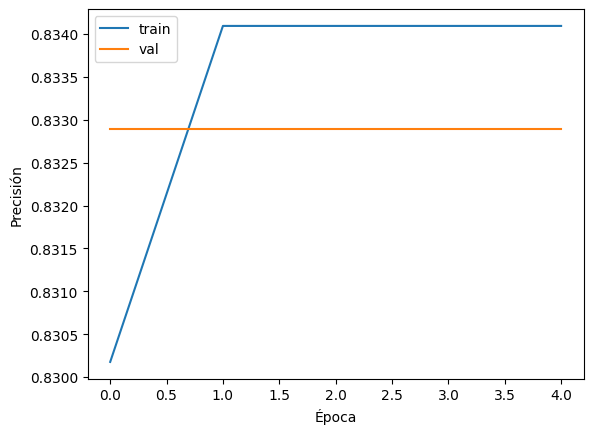

In [8]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend(); plt.xlabel('Época'); plt.ylabel('Precisión'); plt.show()

## 6. Evaluación

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

      biased       0.00      0.00      0.00        64
  non-biased       0.83      1.00      0.91       319

    accuracy                           0.83       383
   macro avg       0.42      0.50      0.45       383
weighted avg       0.69      0.83      0.76       383



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


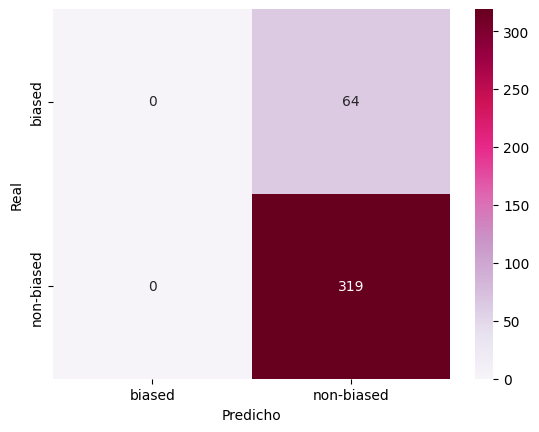

AUC: 0.47756661442006265


In [9]:
y_prob = model.predict(test_ds).ravel()
y_pred = (y_prob > 0.4).astype(int)
y_true = y_test.values

print(classification_report(y_true, y_pred, target_names=['biased','non-biased']))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='PuRd',
            xticklabels=['biased','non-biased'], yticklabels=['biased','non-biased'])
plt.xlabel('Predicho'); plt.ylabel('Real'); plt.show()

fpr,tpr,_ = roc_curve(y_true, y_prob)
print("AUC:", auc(fpr,tpr))


## 7. Próximos pasos
- Aumentar `epochs` si no hay sobreajuste.
- Probar `class_weight={0:1,1:2}` en `model.fit`.
- Cambiar la arquitectura a `Bidirectional(LSTM(32))` para capturar contexto.
- Usar embeddings preentrenados (GloVe) para menos datos.

In [10]:
history = model.fit(train_ds, validation_data=test_ds, epochs=5, class_weight={0:1, 1:2})

Epoch 1/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8262 - loss: 0.6075 - val_accuracy: 0.8329 - val_loss: 0.4756
Epoch 2/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8432 - loss: 0.5507 - val_accuracy: 0.8329 - val_loss: 0.4723
Epoch 3/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8397 - loss: 0.5651 - val_accuracy: 0.8329 - val_loss: 0.4696
Epoch 4/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8280 - loss: 0.5858 - val_accuracy: 0.8329 - val_loss: 0.4725
Epoch 5/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8366 - loss: 0.5559 - val_accuracy: 0.8329 - val_loss: 0.4673


In [11]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_TOKENS, EMBED_DIM, input_length=MAX_LEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), # Capa Bidirectional LSTM
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_lstm = model_lstm.fit(train_ds, validation_data=test_ds, epochs=5)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.7723 - loss: 0.6035 - val_accuracy: 0.8329 - val_loss: 0.4511
Epoch 2/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8325 - loss: 0.4519 - val_accuracy: 0.8329 - val_loss: 0.4465
Epoch 3/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.8233 - loss: 0.4502 - val_accuracy: 0.8329 - val_loss: 0.4408
Epoch 4/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.8461 - loss: 0.3608 - val_accuracy: 0.8329 - val_loss: 0.4292
Epoch 5/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8862 - loss: 0.2352 - val_accuracy: 0.7337 - val_loss: 0.5097


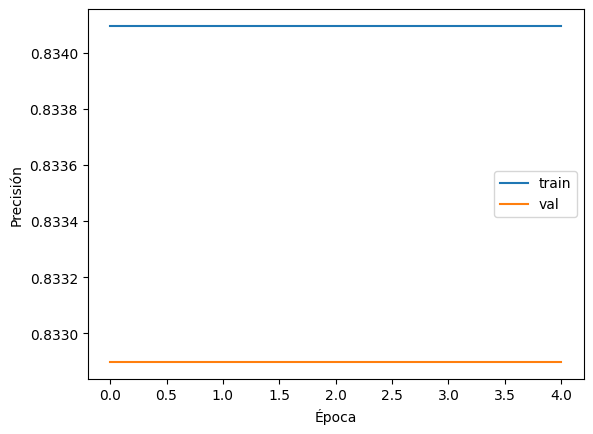

In [12]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend(); plt.xlabel('Época'); plt.ylabel('Precisión'); plt.show()